In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

[*********************100%%**********************]  1 of 1 completed
C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
1/1 - 7s - 7s/step - loss: 0.2640
Epoch 2/200
1/1 - 0s - 47ms/step - loss: 0.2339
Epoch 3/200
1/1 - 0s - 50ms/step - loss: 0.2058
Epoch 4/200
1/1 - 0s - 52ms/step - loss: 0.1796
Epoch 5/200
1/1 - 0s - 46ms/step - loss: 0.1555
Epoch 6/200
1/1 - 0s - 88ms/step - loss: 0.1340
Epoch 7/200
1/1 - 0s - 72ms/step - loss: 0.1158
Epoch 8/200
1/1 - 0s - 75ms/step - loss: 0.1021
Epoch 9/200
1/1 - 0s - 76ms/step - loss: 0.0945
Epoch 10/200
1/1 - 0s - 55ms/step - loss: 0.0941
Epoch 11/200
1/1 - 0s - 81ms/step - loss: 0.0994
Epoch 12/200
1/1 - 0s - 67ms/step - loss: 0.1055
Epoch 13/200
1/1 - 0s - 76ms/step - loss: 0.1081
Epoch 14/200
1/1 - 0s - 76ms/step - loss: 0.1064
Epoch 15/200
1/1 - 0s - 72ms/step - loss: 0.1019
Epoch 16/200
1/1 - 0s - 73ms/step - loss: 0.0964
Epoch 17/200
1/1 - 0s - 68ms/step - loss: 0.0915
Epoch 18/200
1/1 - 0s - 63ms/step - loss: 0.0878
Epoch 19/200
1/1 - 0s - 76ms/step - loss: 0.0855
Epoch 20/200
1/1 - 0s - 72ms/step - loss: 0.0844
Epoch 21/200
1/1 - 0s - 50ms/st

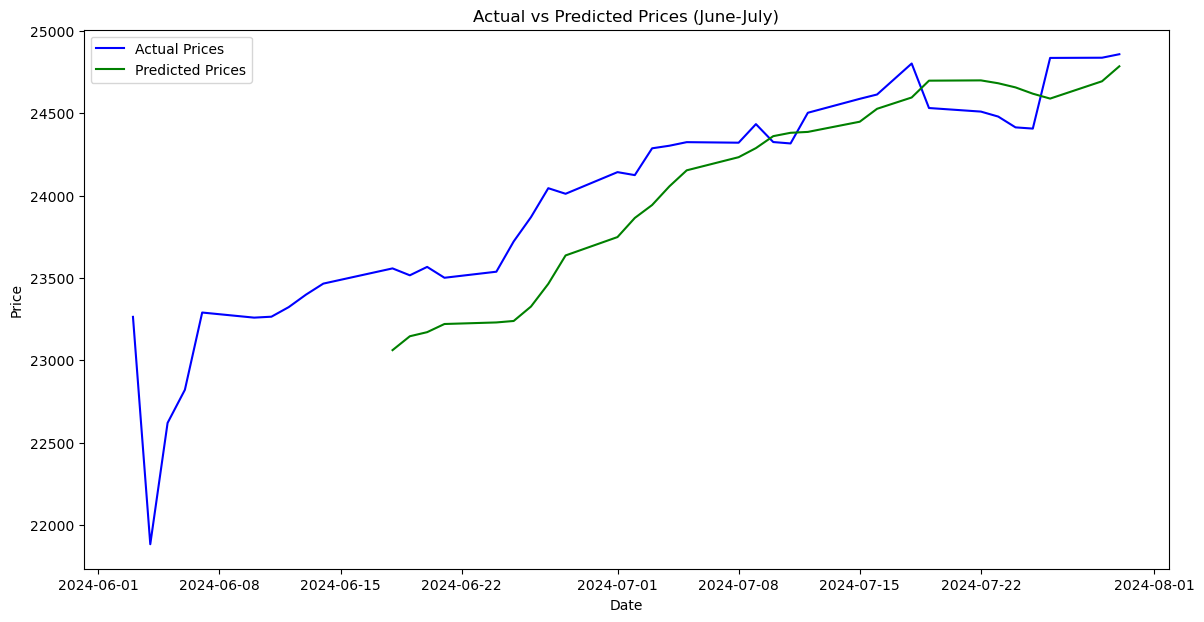

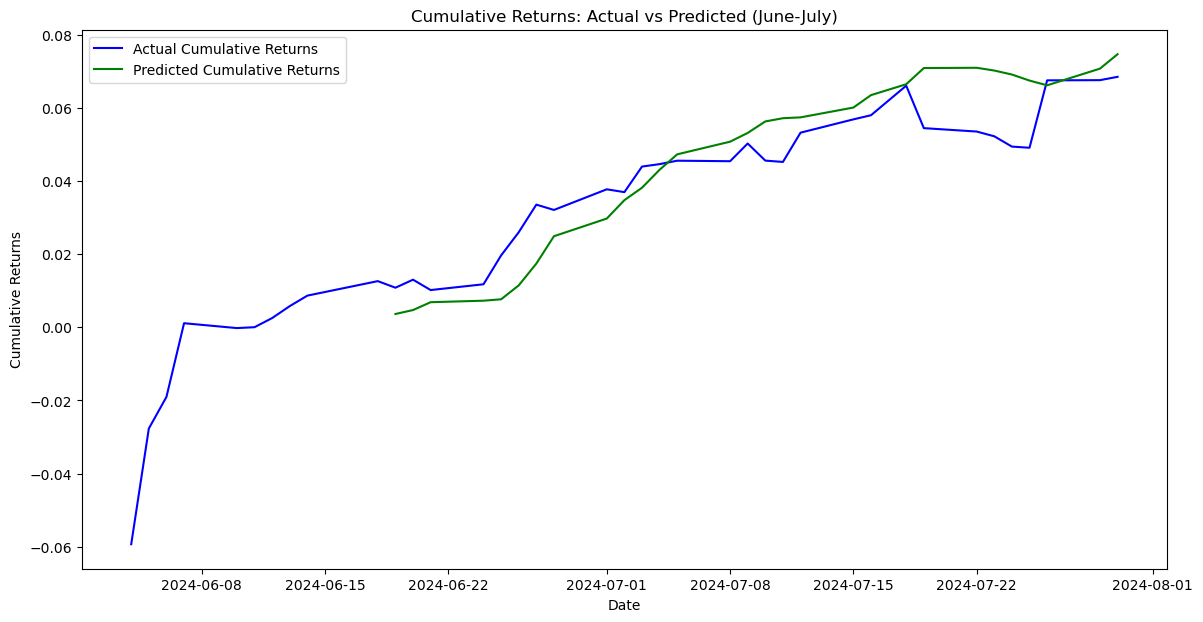

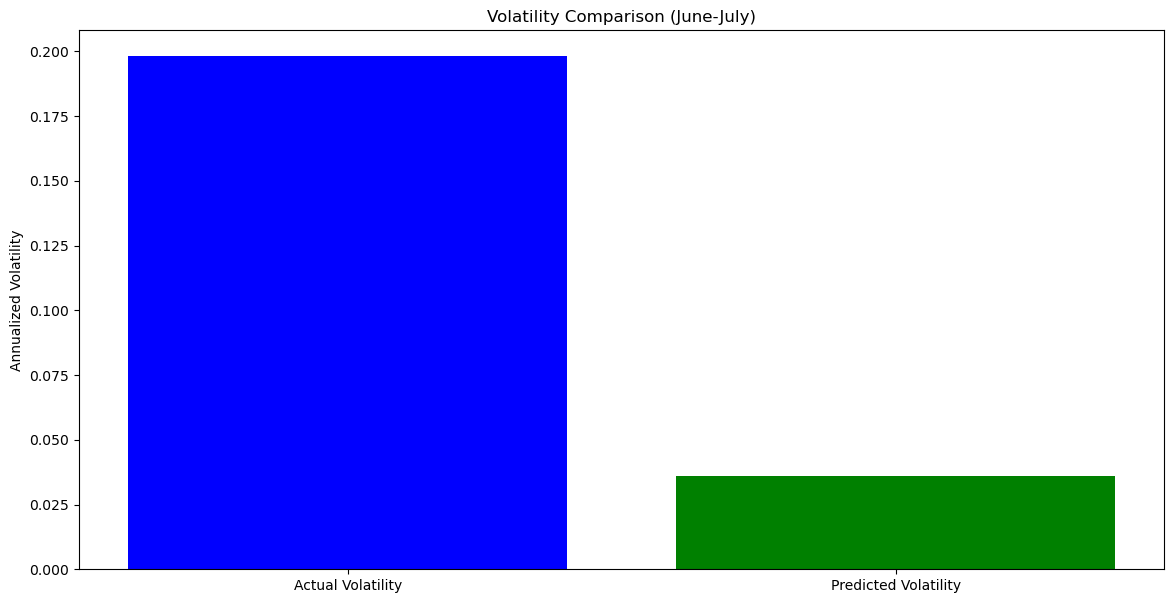

In [3]:
# Step 1: Data Collection
ticker = '^NSEI'  # Nifty 100 Index
data = yf.download(ticker, start='2024-04-01', end='2024-07-31')
data = data['Close']

# Step 2: Train/Test Split
train_data = data['2024-04-01':'2024-05-31']
test_data = data['2024-06-01':'2024-07-31']

# Step 3: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Step 4: LSTM Model Training
def lstm_model_train(scaled_data, sequence_length=10):  # Adjusted sequence length
    X, y = [], []

    if len(scaled_data) <= sequence_length:
        raise ValueError(f"Insufficient data: Make sure the dataset is larger than {sequence_length} time steps.")

    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=200, batch_size=32, verbose=2)

    return model

model = lstm_model_train(scaled_train_data)

# Step 5: Prediction for June-July
def predict_future(model, data, sequence_length=10):
    inputs = scaler.transform(data.values.reshape(-1, 1))
    X_test = []

    for i in range(sequence_length, len(inputs)):
        X_test.append(inputs[i-sequence_length:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    return predictions

lstm_forecast = predict_future(model, test_data, sequence_length=10)

# Step 6: Performance Analysis (Comparison of predicted and actual values)
def performance_analysis(predictions, test_data):
    # Align predictions with test data index
    prediction_dates = test_data.index[10:]  # skip first 10 dates because of the sequence length
    predicted_data = pd.DataFrame(predictions, index=prediction_dates, columns=['Predicted'])

    # Calculate returns
    actual_returns = test_data.pct_change().dropna()
    predicted_returns = predicted_data.pct_change().dropna()

    # Calculate volatility (standard deviation of returns)
    actual_volatility = actual_returns.std() * np.sqrt(252)  # Annualized volatility
    predicted_volatility = predicted_returns.std() * np.sqrt(252)  # Annualized volatility

    # Calculate cumulative returns
    actual_cumulative_returns = (1 + actual_returns).cumprod() - 1
    predicted_cumulative_returns = (1 + predicted_returns).cumprod() - 1

    # Calculate Sharpe ratio (Assume risk-free rate = 0 for simplicity)
    actual_sharpe_ratio = actual_returns.mean() / actual_returns.std() * np.sqrt(252)
    predicted_sharpe_ratio = predicted_returns.mean() / predicted_returns.std() * np.sqrt(252)

    # Convert volatility and Sharpe ratios to scalar values if they are Series
    actual_volatility_value = actual_volatility if isinstance(actual_volatility, float) else actual_volatility.values[0]
    predicted_volatility_value = predicted_volatility if isinstance(predicted_volatility, float) else predicted_volatility.values[0]
    actual_sharpe_ratio_value = actual_sharpe_ratio if isinstance(actual_sharpe_ratio, float) else actual_sharpe_ratio.values[0]
    predicted_sharpe_ratio_value = predicted_sharpe_ratio if isinstance(predicted_sharpe_ratio, float) else predicted_sharpe_ratio.values[0]

    # Print performance metrics
    print(f"Actual Volatility: {actual_volatility_value:.4f}")
    print(f"Predicted Volatility: {predicted_volatility_value:.4f}")
    print(f"Actual Sharpe Ratio: {actual_sharpe_ratio_value:.4f}")
    print(f"Predicted Sharpe Ratio: {predicted_sharpe_ratio_value:.4f}")

    # Plot predicted prices vs actual prices
    plt.figure(figsize=(14, 7))
    plt.plot(test_data.index, test_data, label='Actual Prices', color='blue')
    plt.plot(predicted_data.index, predicted_data['Predicted'], label='Predicted Prices', color='green')
    plt.title('Actual vs Predicted Prices (June-July)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Plot cumulative returns
    plt.figure(figsize=(14, 7))
    plt.plot(actual_cumulative_returns, label='Actual Cumulative Returns', color='blue')
    plt.plot(predicted_cumulative_returns, label='Predicted Cumulative Returns', color='green')
    plt.title('Cumulative Returns: Actual vs Predicted (June-July)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

    # Plot volatility comparison
    plt.figure(figsize=(14, 7))
    plt.bar(['Actual Volatility', 'Predicted Volatility'], [actual_volatility_value, predicted_volatility_value], color=['blue', 'green'])
    plt.title('Volatility Comparison (June-July)')
    plt.ylabel('Annualized Volatility')
    plt.show()

# Run performance analysis
performance_analysis(lstm_forecast, test_data)

Episode 1/500, Reward: 20.000000, Max Drawdown: 0.000000, Sharpe Ratio: nan, Epsilon: 1.000000
Episode 2/500, Reward: 14.000000, Max Drawdown: 0.300000, Sharpe Ratio: 5.666667, Epsilon: 0.995000
Episode 3/500, Reward: 25.000000, Max Drawdown: 0.300000, Sharpe Ratio: 4.373371, Epsilon: 0.990025
Episode 4/500, Reward: 37.000000, Max Drawdown: 0.300000, Sharpe Ratio: 2.838300, Epsilon: 0.985075
Episode 5/500, Reward: 32.000000, Max Drawdown: 0.300000, Sharpe Ratio: 3.117319, Epsilon: 0.980150
Episode 6/500, Reward: 43.000000, Max Drawdown: 0.300000, Sharpe Ratio: 2.875270, Epsilon: 0.975249
Episode 7/500, Reward: 16.000000, Max Drawdown: 0.627907, Sharpe Ratio: 2.627815, Epsilon: 0.970373
Episode 8/500, Reward: 50.000000, Max Drawdown: 0.627907, Sharpe Ratio: 2.421016, Epsilon: 0.965521
Episode 9/500, Reward: 19.000000, Max Drawdown: 0.627907, Sharpe Ratio: 2.368341, Epsilon: 0.960693
Episode 10/500, Reward: 31.000000, Max Drawdown: 0.627907, Sharpe Ratio: 2.513197, Epsilon: 0.955890
Epis

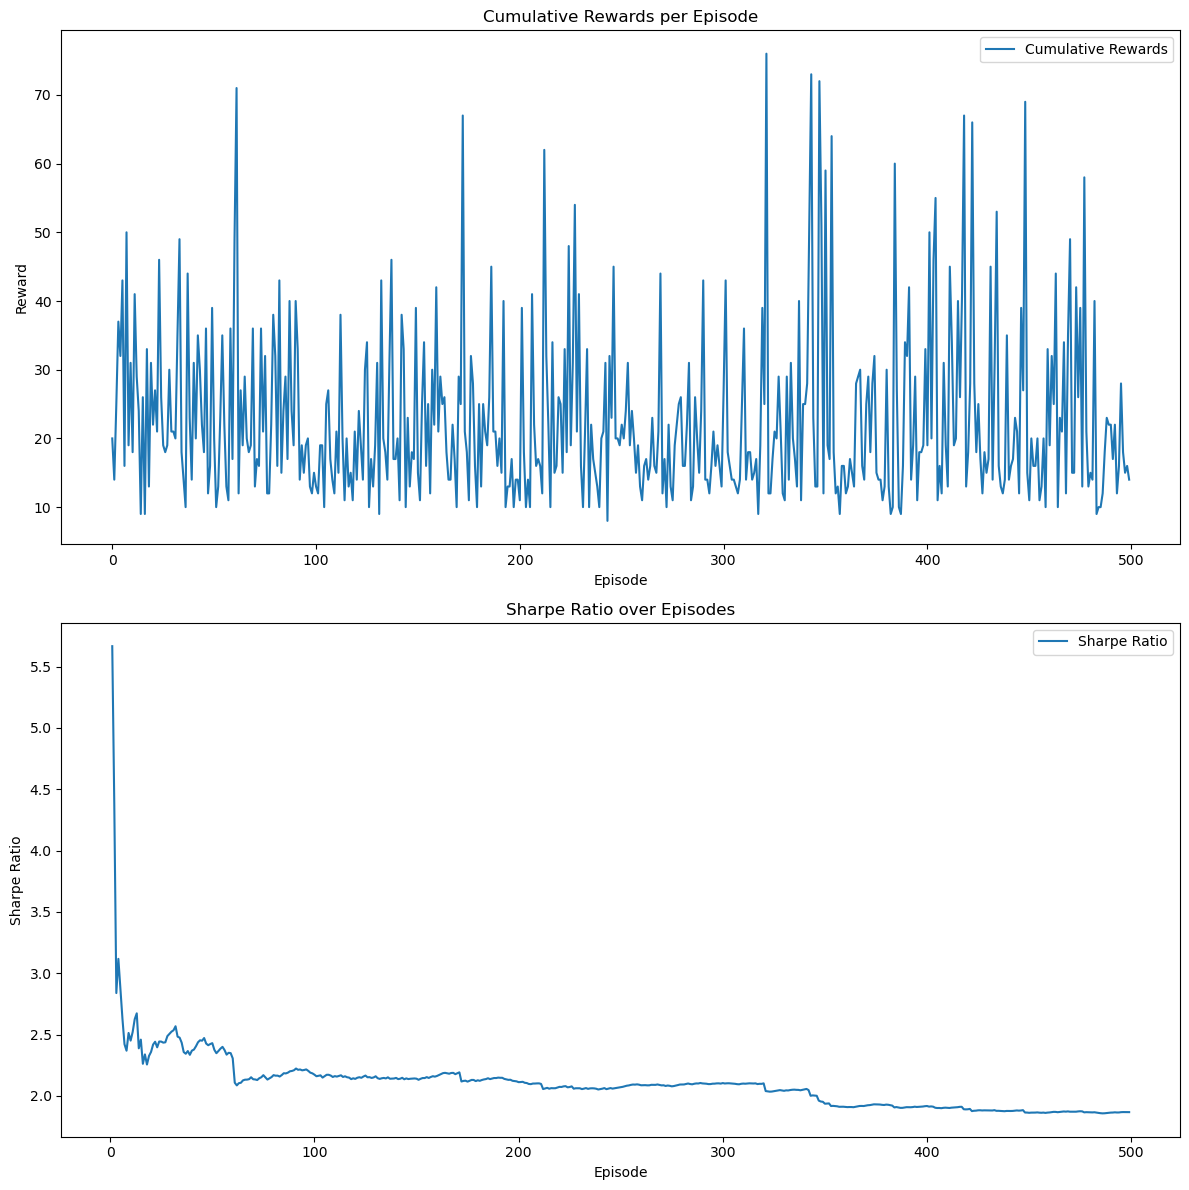

In [21]:
import gym
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from collections import deque
from tabulate import tabulate  # Import tabulate for tabular display

# Define calculation functions
def calculate_max_drawdown(rewards):
    peak = -np.inf
    max_drawdown = 0
    for reward in rewards:
        peak = max(peak, reward)
        drawdown = (peak - reward) / peak
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown

def calculate_sharpe_ratio(rewards):
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    if std_reward == 0:
        return np.nan
    return mean_reward / std_reward

# Environment setup
env = gym.make('CartPole-v1')
state_shape = env.observation_space.shape[0]
action_size = env.action_space.n

# Parameters
episodes = 500
gamma = 0.95  # Discount rate
epsilon = 1.0  # Exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
learning_rate = 0.001
batch_size = 32
memory = deque(maxlen=2000)

# Model setup
model = Sequential([
    tf.keras.Input(shape=(state_shape,)),
    Dense(24, activation='relu'),
    Dense(24, activation='relu'),
    Dense(action_size, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

target_model = tf.keras.models.clone_model(model)
target_model.set_weights(model.get_weights())

@tf.function
def replay():
    if len(memory) < batch_size:
        return

    minibatch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.array([state[0] for state in states]).astype(np.float32)
    next_states = np.array([next_state[0] for next_state in next_states]).astype(np.float32)

    targets = np.array(rewards) + gamma * np.amax(target_model(next_states, training=False), axis=1) * (1 - np.array(dones))
    target_f = model(states, training=False)
    
    for i, action in enumerate(actions):
        target_f[i][action] = targets[i]
    
    model.fit(states, target_f, epochs=1, verbose=0)
    
    # Update the target model
    target_model.set_weights(model.get_weights())

@tf.function
def act(state):
    if tf.random.uniform(()) <= epsilon:
        return tf.random.uniform((), maxval=action_size, dtype=tf.int64)
    act_values = model(state, training=False)
    return tf.argmax(act_values[0])

# Initialize lists for plotting and tabular results
all_rewards = []  # Initialize all_rewards
cumulative_rewards = []
drawdowns = []
sharpe_ratios = []
results = []  # List to store results for tabular output

# Training loop
for episode in range(episodes):
    state, _ = env.reset()  # Unpack the state, ignoring the info
    state = np.reshape(state, [1, state_shape]).astype(np.float32)  # Ensure consistent dtype
    total_reward = 0
    
    while True:
        action = act(state).numpy()  # Convert the tensor to a Python integer
        next_state, reward, done, truncated, info = env.step(action)  # Unpack all five values
        next_state = np.reshape(next_state, [1, state_shape]).astype(np.float32)
        memory.append((state, action, reward, next_state, done))
        
        state = next_state
        total_reward += reward
        
        if done:
            all_rewards.append(total_reward)
            max_drawdown = calculate_max_drawdown(all_rewards)
            sharpe_ratio = calculate_sharpe_ratio(all_rewards)
            # Format values to six decimal places
            total_reward = f"{total_reward:.6f}"
            max_drawdown = f"{max_drawdown:.6f}"
            sharpe_ratio = f"{sharpe_ratio:.6f}"
            epsilon_formatted = f"{epsilon:.6f}"
            # Print individual episode data
            print(f"Episode {episode + 1}/{episodes}, Reward: {total_reward}, Max Drawdown: {max_drawdown}, Sharpe Ratio: {sharpe_ratio}, Epsilon: {epsilon_formatted}")
            # Append data for tabular output
            results.append([episode + 1, total_reward, max_drawdown, sharpe_ratio, epsilon_formatted])
            cumulative_rewards.append(float(total_reward))
            drawdowns.append(float(max_drawdown))
            sharpe_ratios.append(float(sharpe_ratio))
            break
    
        replay()
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Plotting reward and risk metrics
plt.figure(figsize=(12, 12))

# Plot cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Cumulative Rewards per Episode')
plt.legend()

# Plot Sharpe ratio
plt.subplot(2, 1, 2)
plt.plot(sharpe_ratios, label='Sharpe Ratio')
plt.xlabel('Episode')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio over Episodes')
plt.legend()

plt.tight_layout()
plt.show()